In [3]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import altair as alt
alt.renderers.enable('mimetype')
pm.__version__

'5.0.2'

In [4]:
bangladesh = pd.read_csv('../../../datasets/bangladesh.csv')

In [5]:
d_idx, districts = pd.factorize(bangladesh['district'])

# Replicating lecture results

## Centered parameterization

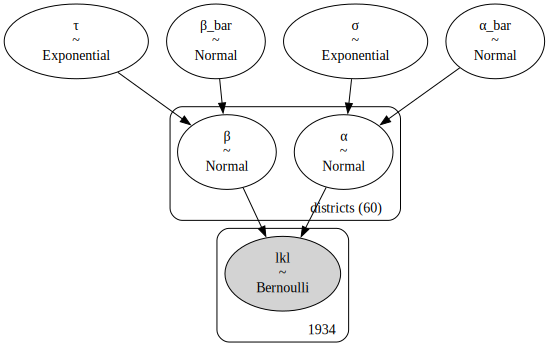

In [6]:
with pm.Model(coords = {"districts": districts}) as lecture_model:
    σ = pm.Exponential("σ", 1)
    τ = pm.Exponential("τ", 1)
    α_bar = pm.Normal("α_bar", 0, 1)
    β_bar = pm.Normal("β_bar", 0, 1)
    α = pm.Normal("α", α_bar, σ, dims="districts")
    β = pm.Normal("β", β_bar, τ, dims="districts")

    logit = α[d_idx] + β[d_idx]*bangladesh['urban'].values

    pm.Bernoulli("lkl", logit_p = logit, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(lecture_model)

In [7]:
with lecture_model:
    lecture_trace = pm.sampling_jax.sample_blackjax_nuts()

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:01.971038
Sampling...
Sampling time =  0:00:07.079260
Transforming variables...
Transformation time =  0:00:06.052225


In [8]:
az.summary(lecture_trace, round_to=2, var_names=["α_bar", "β_bar", "σ", "τ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_bar,-0.70,0.09,-0.88,-0.53,0.00,0.00,2050.00,2956.65,1.00
β_bar,0.62,0.16,0.33,0.92,0.00,0.00,1392.73,2012.32,1.00
σ,0.49,0.09,0.32,0.66,0.00,0.00,602.01,818.64,1.00
τ,0.57,0.21,0.18,0.95,0.02,0.01,139.76,161.41,1.02


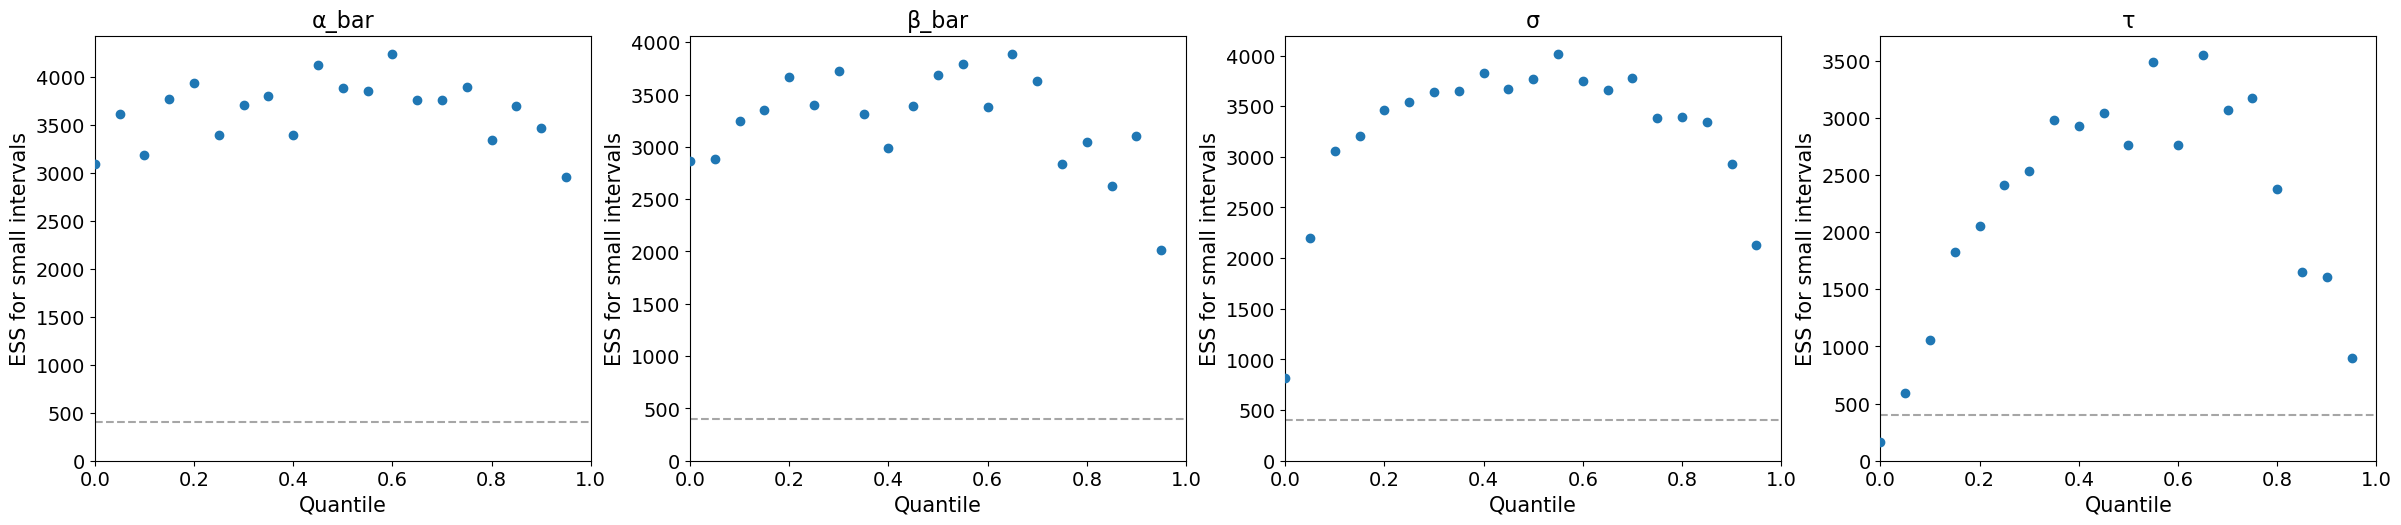

In [9]:
az.plot_ess(lecture_trace, var_names=["α_bar", "β_bar", "σ", "τ"])
plt.show()

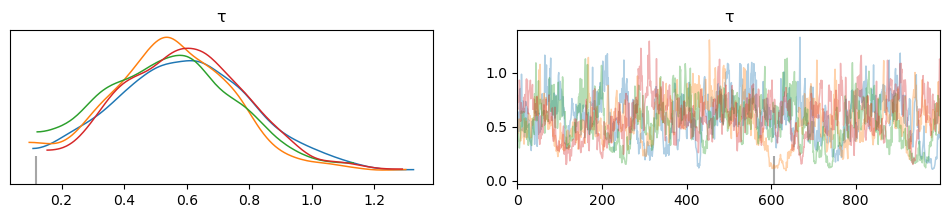

In [10]:
az.plot_trace(lecture_trace, var_names=["τ"], kind="trace", figsize=(12,2), chain_prop="color")
plt.show()

## Non-centered parameterization

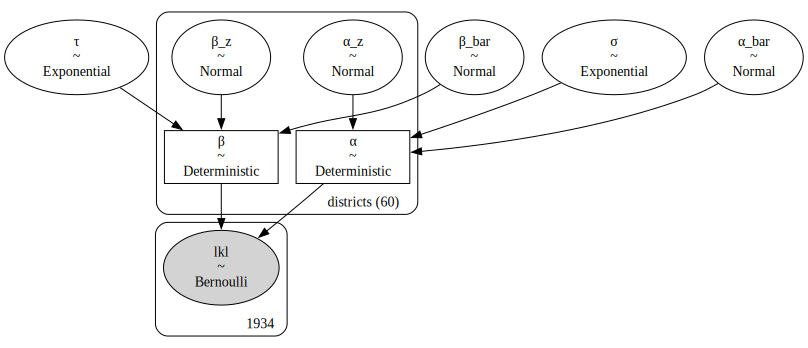

In [11]:
with pm.Model(coords = {"districts": districts}) as non_c_lecture_model:
    σ = pm.Exponential("σ", 1)
    τ = pm.Exponential("τ", 1)
    α_bar = pm.Normal("α_bar", 0, 1)
    β_bar = pm.Normal("β_bar", 0, 1)
    α_z = pm.Normal("α_z", 0, 1, dims="districts")
    β_z = pm.Normal("β_z", 0, 1, dims="districts")
    α = pm.Deterministic("α", α_bar + α_z * σ, dims="districts")
    β = pm.Deterministic("β", β_bar + β_z * τ, dims="districts")

    logit = α[d_idx] + β[d_idx]*bangladesh['urban'].values

    pm.Bernoulli("lkl", logit_p = logit, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(non_c_lecture_model)

In [12]:
with non_c_lecture_model:
    non_c_lecture_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:01.777788
Sampling...
Sampling time =  0:00:11.096900
Transforming variables...
Transformation time =  0:00:10.738595


In [13]:
az.summary(non_c_lecture_trace, round_to=2, var_names=["α_bar", "β_bar", "σ", "τ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_bar,-0.70,0.09,-0.87,-0.54,0.00,0.00,2243.02,2452.71,1.00
β_bar,0.62,0.15,0.35,0.92,0.00,0.00,2822.16,2794.68,1.00
σ,0.48,0.09,0.32,0.66,0.00,0.00,1168.41,1981.12,1.00
τ,0.54,0.22,0.10,0.92,0.01,0.01,902.74,872.78,1.01


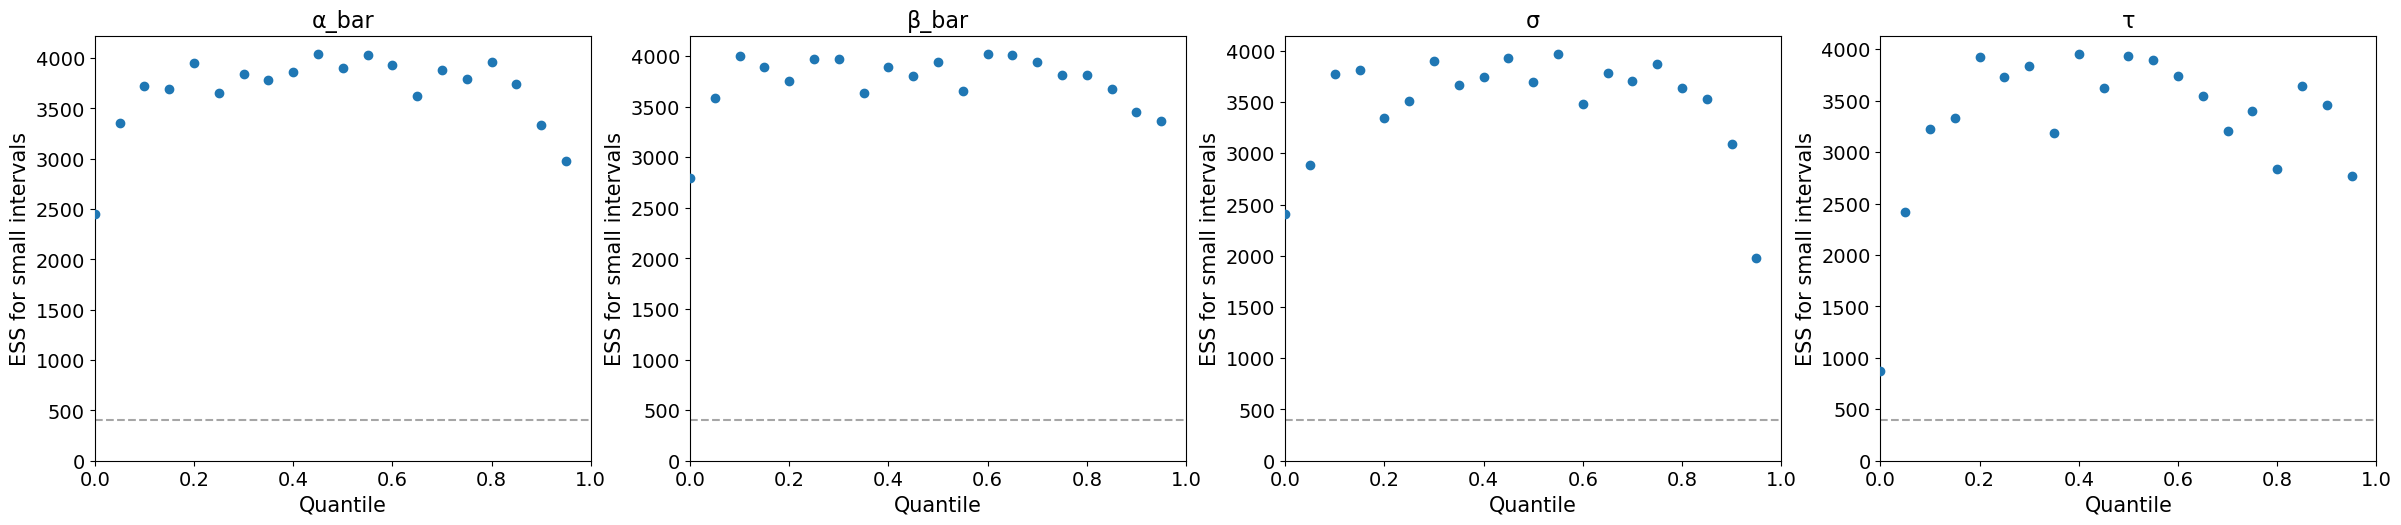

In [14]:
az.plot_ess(non_c_lecture_trace, var_names=["α_bar", "β_bar", "σ", "τ"])
plt.show()

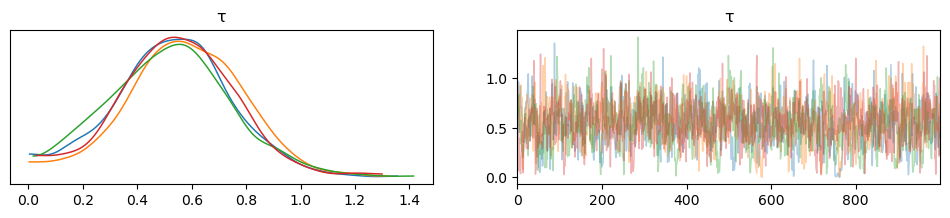

In [15]:
az.plot_trace(non_c_lecture_trace, var_names=["τ"], kind="trace", figsize=(12,2), chain_prop="color")
plt.show()

## Multivariate centered parameterization

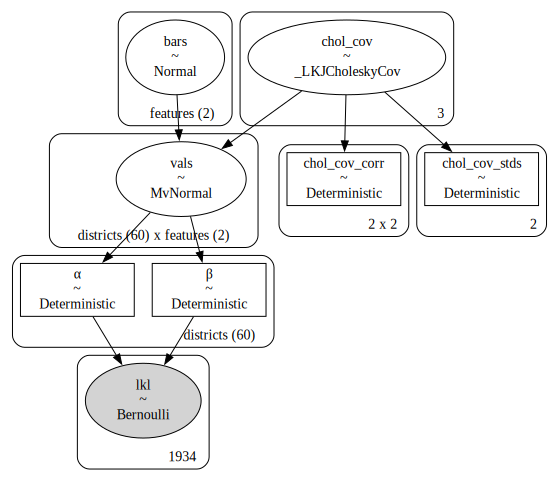

In [16]:
with pm.Model(coords = {
    "districts": districts,
    "features": ["district", "urban"]
}) as mv_centered_lecture_model:
    σ = pm.Exponential.dist(1.0, shape=2)
    bars = pm.Normal("bars", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=4, sd_dist=σ, compute_corr=True)
    vals = pm.MvNormal('vals', mu=bars, chol=chol, dims=["districts", "features",])    

    α = pm.Deterministic("α", vals[:, 0], dims="districts")
    β = pm.Deterministic("β", vals[:, 1], dims="districts") 

    logit = α[d_idx] + β[d_idx]*bangladesh['urban'].values

    pm.Bernoulli("lkl", logit_p = logit, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(mv_centered_lecture_model)

In [17]:
with mv_centered_lecture_model:
    mv_centered_lecture_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:04.659416
Sampling...
Sampling time =  0:00:09.406083
Transforming variables...
Transformation time =  0:00:10.301687


In [18]:
az.summary(mv_centered_lecture_trace, round_to=2)

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bars[district],-0.70,0.10,-0.90,-0.53,0.00,0.00,2174.89,2772.87,1.0
bars[urban],0.68,0.17,0.36,1.00,0.00,0.00,1641.81,2088.66,1.0
"vals[1, district]",-1.52,0.31,-2.12,-0.97,0.01,0.00,2819.54,2664.72,1.0
"vals[1, urban]",1.01,0.38,0.27,1.70,0.01,0.01,2695.86,2672.19,1.0
"vals[2, district]",-0.66,0.36,-1.36,-0.00,0.01,0.00,5055.25,3028.33,1.0
...,...,...,...,...,...,...,...,...,...
β[57],0.80,0.62,-0.37,1.95,0.01,0.01,3854.92,3102.79,1.0
β[58],-0.13,0.55,-1.22,0.84,0.01,0.01,2195.13,2640.28,1.0
β[59],1.01,0.76,-0.40,2.45,0.01,0.01,3240.46,2959.77,1.0
β[60],0.70,0.57,-0.29,1.86,0.01,0.01,3888.83,2666.47,1.0


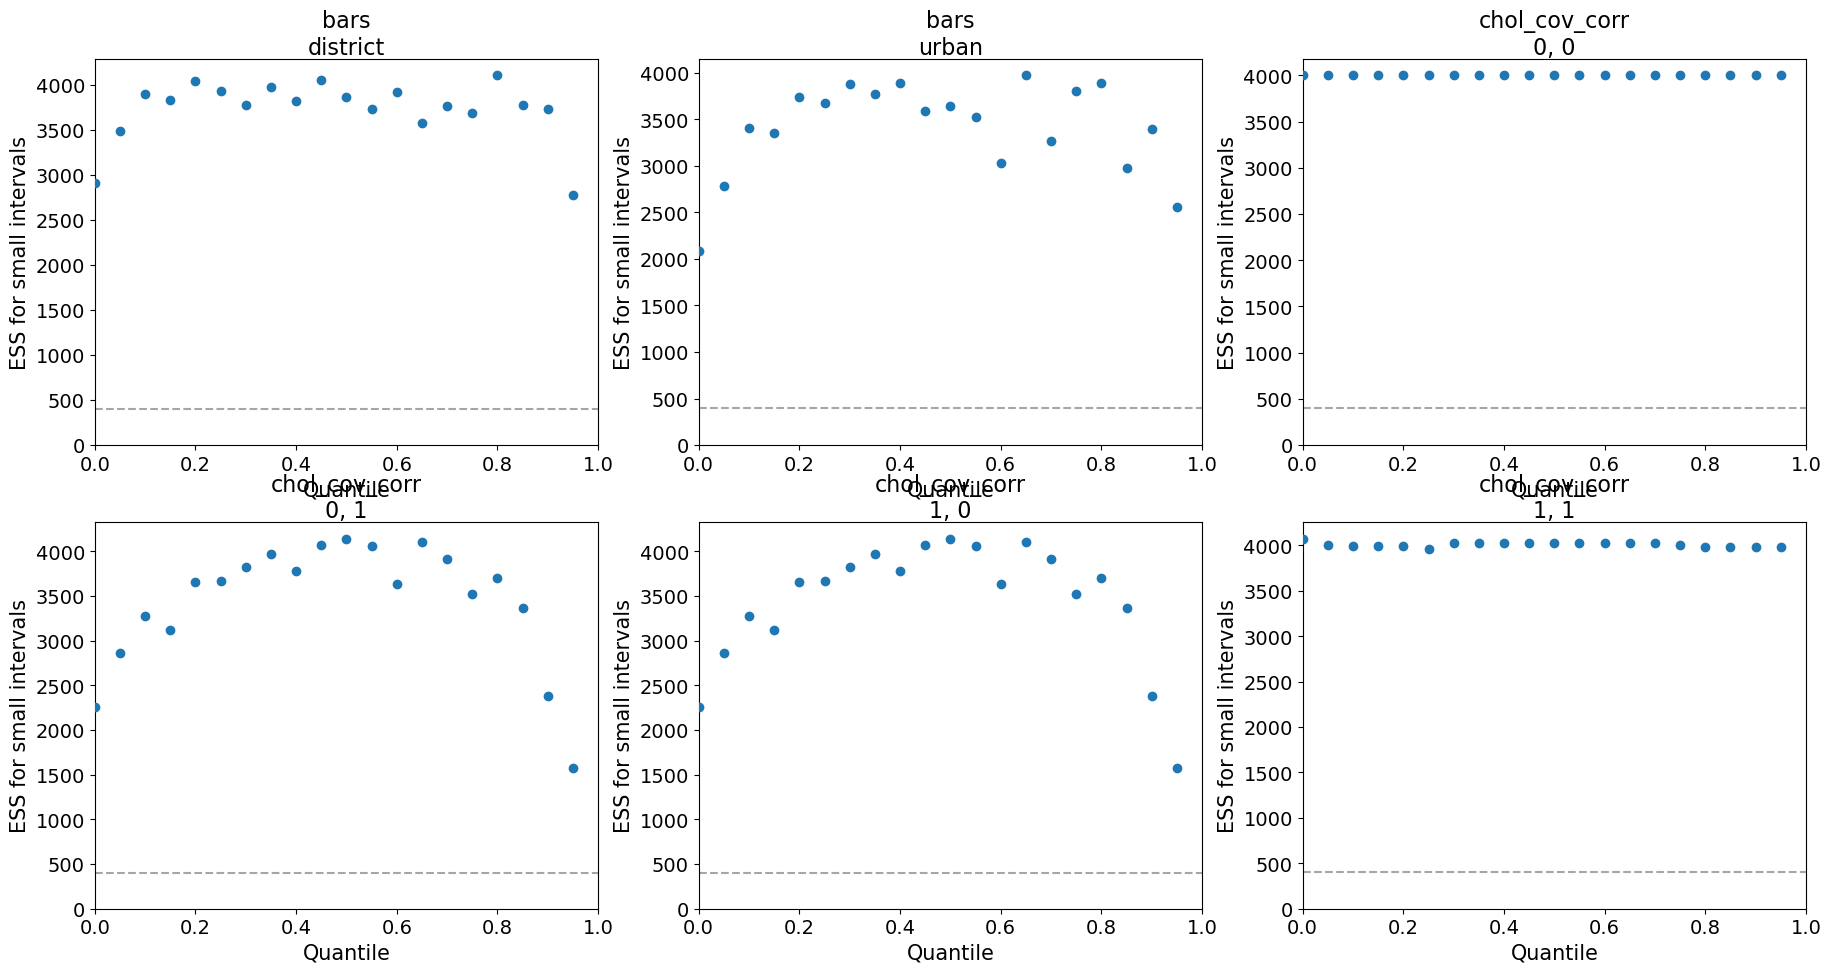

In [19]:
az.plot_ess(mv_centered_lecture_trace, var_names=["bars", "chol_cov_corr"])
plt.show()

## Multivariate non-centered parameterization (pyMC style)

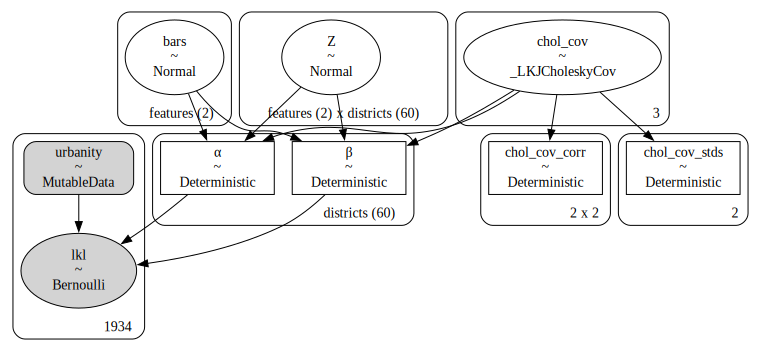

In [20]:
with pm.Model(coords = {
    "districts": districts,
    "features": ["district", "urban"]
}) as mv_non_centered_lecture_model:
    urbanity = pm.MutableData("urbanity", bangladesh['urban'].values)
    σ = pm.Exponential.dist(1.0, shape=2)
    bars = pm.Normal("bars", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=4, sd_dist=σ, compute_corr=True)

    Z = pm.Normal('Z', mu=0, sigma=1, dims=["features", "districts"])
    vals = pm.math.dot(chol, Z)
        
    α = pm.Deterministic("α", bars[0] + vals[0, :], dims="districts")
    β = pm.Deterministic("β", bars[1] + vals[1, :], dims="districts") 

    logit = α[d_idx] + β[d_idx]*urbanity

    pm.Bernoulli("lkl", logit_p = logit, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(mv_non_centered_lecture_model)

In [21]:
with mv_non_centered_lecture_model:
    mv_non_centered_lecture_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bars, chol_cov, Z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [22]:
az.summary(mv_non_centered_lecture_trace, round_to=2, var_names=['bars', 'chol_cov_stds', 'chol_cov_corr'])

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bars[district],-0.70,0.10,-0.90,-0.53,0.00,0.0,3571.61,3207.47,1.0
bars[urban],0.68,0.16,0.37,0.98,0.00,0.0,4313.89,3320.03,1.0
chol_cov_stds[0],0.55,0.10,0.38,0.73,0.00,0.0,1611.55,2559.02,1.0
chol_cov_stds[1],0.74,0.20,0.35,1.11,0.01,0.0,1411.75,1974.56,1.0
"chol_cov_corr[0, 0]",1.00,0.00,1.00,1.00,0.00,0.0,4000.00,4000.00,NaN
"chol_cov_corr[0, 1]",-0.54,0.19,-0.86,-0.20,0.00,0.0,2516.88,3173.83,1.0
"chol_cov_corr[1, 0]",-0.54,0.19,-0.86,-0.20,0.00,0.0,2516.88,3173.83,1.0
"chol_cov_corr[1, 1]",1.00,0.00,1.00,1.00,0.00,0.0,3941.99,3724.22,1.0


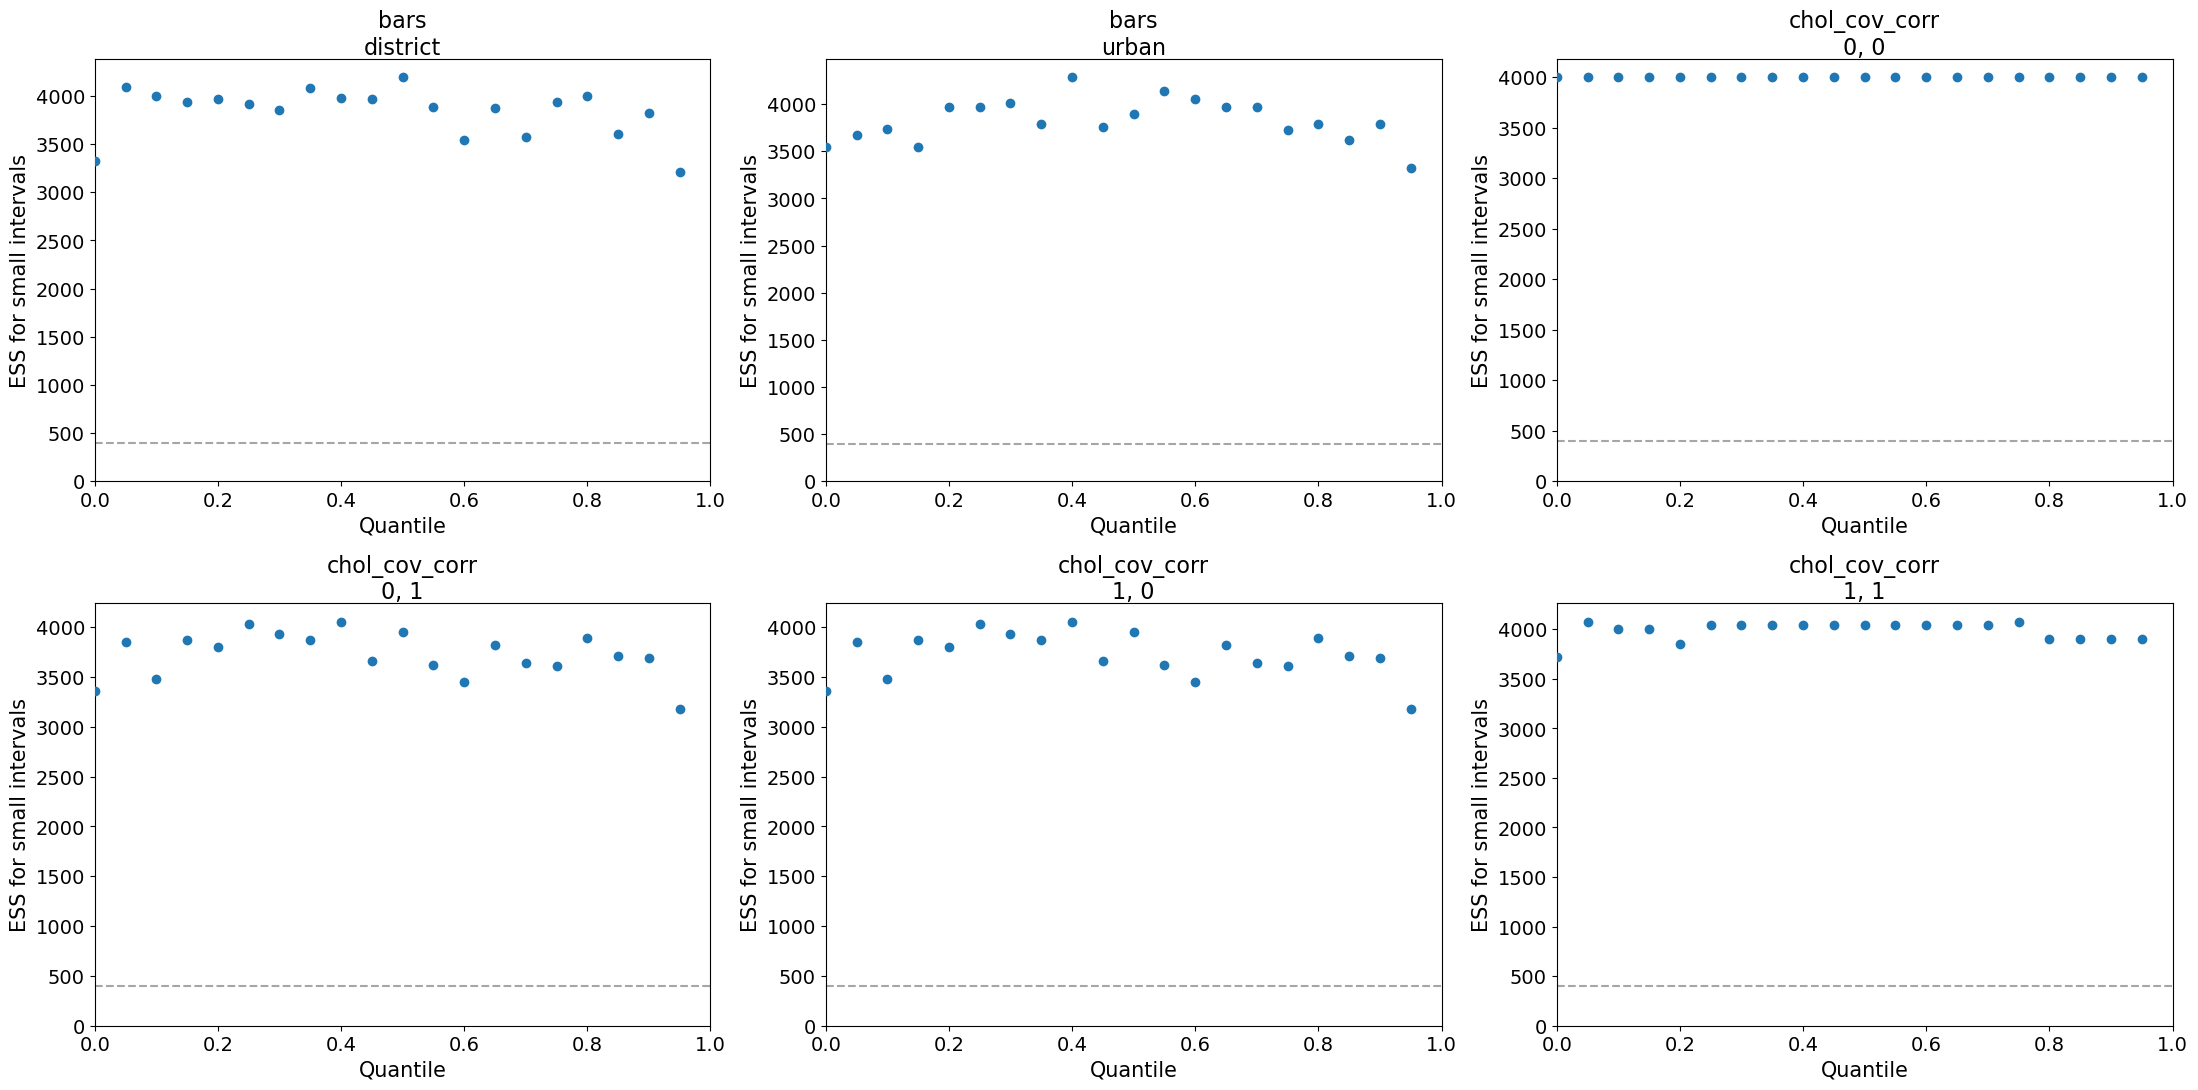

In [23]:
az.plot_ess(mv_non_centered_lecture_trace, var_names=["bars", "chol_cov_corr"])
plt.tight_layout()
plt.show()

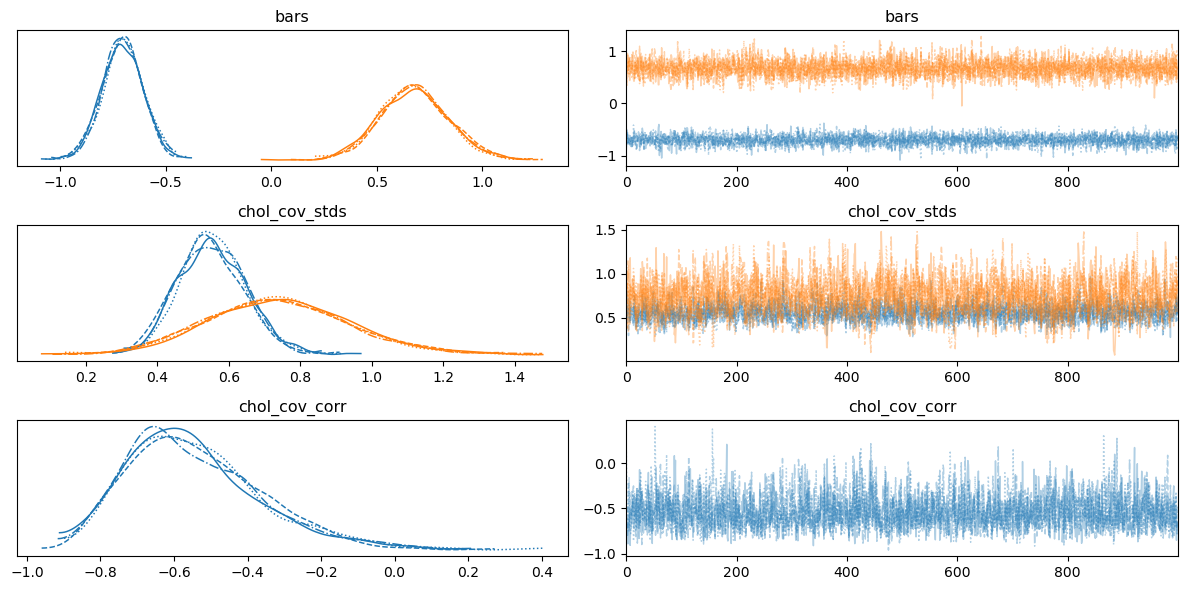

In [24]:
az.plot_trace(
    mv_non_centered_lecture_trace, 
    var_names=['bars', 'chol_cov_stds', 'chol_cov_corr'],
    coords={"chol_cov_corr_dim_0": 0, "chol_cov_corr_dim_1": 1}
)
plt.tight_layout()
plt.show()

In [25]:
from scipy.special import expit
import altair as alt

In [26]:
rural_probs = expit(mv_non_centered_lecture_trace['posterior']['α']).mean(dim=['chain', 'draw']).to_numpy()
urban_probs = expit(mv_non_centered_lecture_trace['posterior']['α'] + mv_non_centered_lecture_trace['posterior']['β']).mean(dim=['chain', 'draw']).to_numpy()
α = mv_non_centered_lecture_trace['posterior']['α'].mean(dim=['chain', 'draw']).to_numpy()
β = mv_non_centered_lecture_trace['posterior']['β'].mean(dim=['chain', 'draw']).to_numpy()

mv_df = pd.DataFrame({
    'rural': rural_probs, 'urban': urban_probs, 'a': α, 'b': β, "model": 'multivariate'
}).reset_index(names="district")

In [27]:
rural_probs = expit(non_c_lecture_trace['posterior']['α']).mean(dim=['chain', 'draw']).to_numpy()
urban_probs = expit(non_c_lecture_trace['posterior']['α'] + non_c_lecture_trace['posterior']['β']).mean(dim=['chain', 'draw']).to_numpy()

α = non_c_lecture_trace['posterior']['α'].mean(dim=['chain', 'draw']).to_numpy()
β = non_c_lecture_trace['posterior']['β'].mean(dim=['chain', 'draw']).to_numpy()

uni_df = pd.DataFrame({
    'rural': rural_probs, 'urban': urban_probs, 'a': α, 'b': β, 'model': 'univariate'
}).reset_index(names="district")

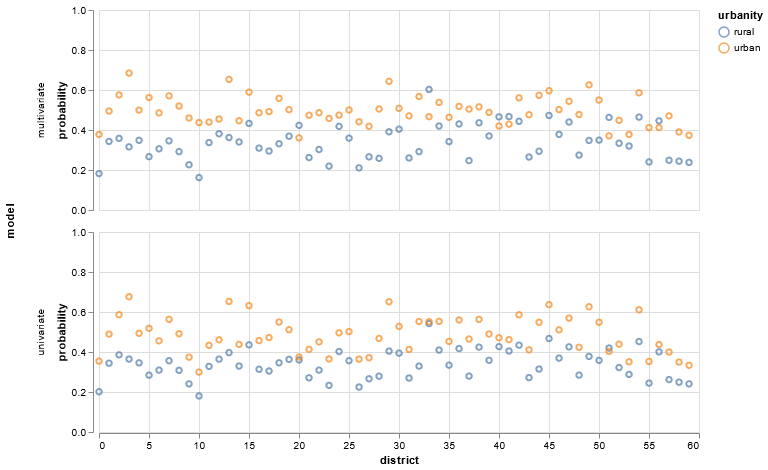

In [28]:
melted = pd.concat([mv_df, uni_df]).melt(id_vars=["district", "model"], var_name="urbanity", value_name="probability", value_vars=('rural', 'urban'))

alt.Chart(melted).mark_point().encode(
    alt.X('district'), alt.Y("probability", scale=alt.Scale(domain=[0,1])), alt.Color("urbanity"),
    alt.Row('model')
).properties(width=600, height=200)


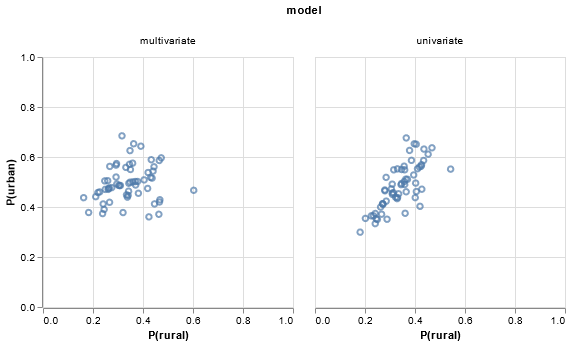

In [29]:
alt.Chart(pd.concat([mv_df, uni_df])).mark_point().encode(
    alt.X('rural', title="P(rural)", scale=alt.Scale(domain=[0,1])), 
    alt.Y("urban", title='P(urban)', scale=alt.Scale(domain=[0,1])), 
    alt.Column("model"),    
).properties(width=250, height=250)


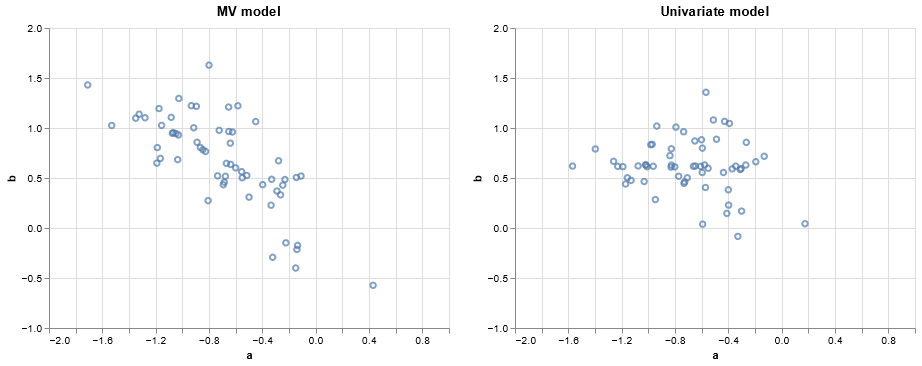

In [30]:
alt.Chart(mv_df).mark_point().encode(
    alt.X('a', scale=alt.Scale(domain=[-2,1])), 
    alt.Y('b', scale=alt.Scale(domain=[-1,2])), 
).properties(title='MV model') | alt.Chart(uni_df).mark_point().encode(
    alt.X('a', scale=alt.Scale(domain=[-2,1])), 
    alt.Y('b', scale=alt.Scale(domain=[-1,2])),
).properties(title="Univariate model")

In [31]:
with mv_non_centered_lecture_model:
    pm.set_data({"urbanity": np.zeros((len(bangladesh),), dtype=np.int32)})
    rural_predictions = pm.sample_posterior_predictive(mv_non_centered_lecture_trace)
    pm.set_data({"urbanity": np.ones((len(bangladesh),), dtype=np.int32)})
    urban_predictions = pm.sample_posterior_predictive(mv_non_centered_lecture_trace)

Sampling: [lkl]


Sampling: [lkl]


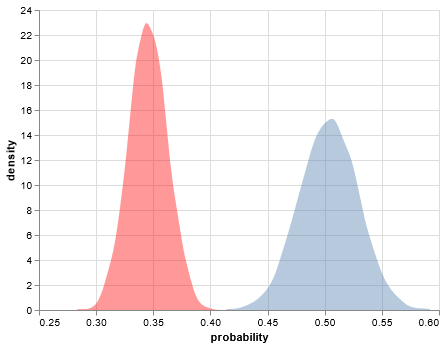

In [32]:
direct_effect = pd.DataFrame({
    "urban" : urban_predictions['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel(),
    "rural" : rural_predictions['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel()
})

alt.Chart(direct_effect).transform_density(
    'rural',
    as_=['probability', 'density'],
).mark_area(opacity=0.4, color='red').encode(
    x="probability:Q",
    y='density:Q',
) + alt.Chart(direct_effect).transform_density(
    'urban',
    as_=['probability', 'density'],
).mark_area(opacity=0.4).encode(
    x="probability:Q",
    y='density:Q',
)

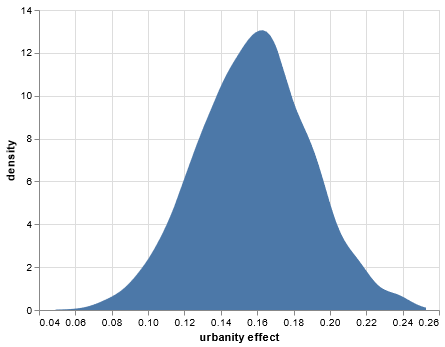

In [33]:
direct_effect = pd.DataFrame((
    urban_predictions['posterior_predictive']['lkl'] - rural_predictions['posterior_predictive']['lkl']
).mean(dim=['lkl_dim_2']).to_numpy().ravel()).rename({0: "urbanity effect"}, axis=1)

alt.Chart(direct_effect).transform_density(
    'urbanity effect',
    as_=['urbanity effect', 'density'],
).mark_area().encode(
    x="urbanity effect:Q",
    y='density:Q',
)